# Transposed Convolution

## Transposed Convの実装

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST
from torchvision.utils import make_grid

%load_ext autoreload
%autoreload 2
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def transposed_conv(X, weight, stride, padding):
    X_b, X_c, X_h, X_w = X.size
    w_in, w_out, w_h, w_w = weight.size
    output_size = stride*(X_h - 1)+ w_h - 2*padding
    output = torch.zeros(output_size, output_size)
    for h in range(X_h):
        for w in range(X_w):
            output[h, w]

In [21]:
def conv_transpose2d(input, weight, stride=1, padding=0):
    batch_size, ch_in, h_in, w_in = input.shape
    _, ch_out, f_h, f_w = weight.shape

    h_out = stride * (h_in - 1) + f_h - 2*padding
    w_out = stride * (w_in - 1) + f_w - 2*padding

    output = torch.zeros((batch_size, ch_out, h_out, w_out))

    for b in range(batch_size):
        for i in range(ch_in):
            for o in range(ch_out):
                for h in range(h_in):
                    for w in range(w_in):
                        h_start = h * stride - padding
                        w_start = w * stride - padding
                        for f_h_idx in range(f_h):
                            for f_w_idx in range(f_w):
                                # 出力位置の計算
                                h_out_idx = h_start + f_h_idx
                                w_out_idx = w_start + f_w_idx
    
                                if 0 <= h_out_idx < h_out and 0 <= w_out_idx < w_out:
                                    output[b, o, h_out_idx, w_out_idx] += input[b, i, h, w] * weight[i, o, f_h_idx, f_w_idx]

    return output            

In [22]:
input = torch.randn(1, 3, 5, 5)
weight = torch.randn(3, 4, 3, 3)
output = conv_transpose2d(input, weight, stride = 2, padding = 2)
print(output.shape)

torch.Size([1, 4, 7, 7])


In [23]:
convt_layer = nn.ConvTranspose2d(3, 4, kernel_size = 3, stride = 2, padding = 2, bias = False)
convt_layer

ConvTranspose2d(3, 4, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), bias=False)

In [24]:
output = convt_layer(input)
output.shape

torch.Size([1, 4, 7, 7])

In [25]:
weight = convt_layer.weight
output_scratch = conv_transpose2d(input, weight, stride = 2, padding = 2)

In [26]:
torch.allclose(output, output_scratch)

True

## Autoencoder

In [42]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder 
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

    def forward(self, X):
        # encoder
        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool(F.relu(self.conv2(X)))
        # decoder
        X = F.relu(self.t_conv1(X))
        X = F.sigmoid(self.t_conv2(X))
        return X

In [43]:
# データ準備
transform = transforms.ToTensor()
train_dataset = MNIST('./mnist_data', train=True, download=True, transform=transform)
val_dataset = MNIST('./mnist_data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)

In [45]:
model = ConvAutoencoder()
# loss_func = F.mse_loss
opt = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

In [31]:
val_loader = DataLoader(val_dataset, batch_size=8)
images, labels = next(iter(val_loader))

In [47]:
# 学習ループ
for epoch in range(1, num_epochs+1):
    
    train_loss = 0.0
    for X, _ in train_loader:
        opt.zero_grad()
        outputs = model(X)
        loss = F.mse_loss(outputs, X)
        loss.backward()
        opt.step()
        train_loss += loss.item()*X.shape[0]
    train_loss = train_loss / len(train_loader)
    print(f'Epoch: {epoch}: train loss: {train_loss}')

Epoch: 1: train loss: 12.282333761898439
Epoch: 2: train loss: 4.017202931426481
Epoch: 3: train loss: 2.6370115585164475
Epoch: 4: train loss: 2.332567609195262
Epoch: 5: train loss: 2.15471668665343
Epoch: 6: train loss: 2.0159659721831016
Epoch: 7: train loss: 1.9226022683608253
Epoch: 8: train loss: 1.860785471223819
Epoch: 9: train loss: 1.8157691334737645
Epoch: 10: train loss: 1.7811265372391194


In [48]:
val_loader = DataLoader(val_dataset, batch_size=8)
images, labels = next(iter(val_loader))

In [49]:
outputs = model(images)

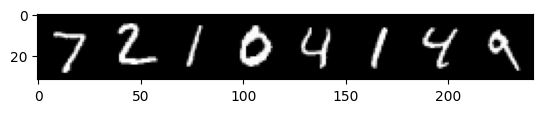

In [53]:
images_grid = make_grid(images)
outputs_grid = make_grid(outputs)
plt.imshow(torch.permute(images_grid, (1, 2, 0)))

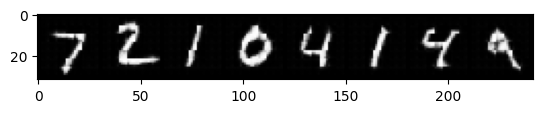

In [54]:
plt.imshow(torch.permute(outputs_grid, (1, 2, 0)))